In [1]:
import requests
import os

if not os.path.exists("data.zip"):
    with requests.get("https://archive.ics.uci.edu/static/public/401/gene+expression+cancer+rna+seq.zip", stream=True) as r:
        r.raise_for_status()
        with open("data.zip", 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                f.write(chunk)

In [2]:
import zipfile
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [3]:
os.system("tar xzvf TCGA-PANCAN-HiSeq-801x20531.tar.gz")

TCGA-PANCAN-HiSeq-801x20531/
TCGA-PANCAN-HiSeq-801x20531/data.csv
TCGA-PANCAN-HiSeq-801x20531/labels.csv


0

In [4]:
import pandas as pd
X = pd.read_csv("./TCGA-PANCAN-HiSeq-801x20531/data.csv")
y = pd.read_csv("./TCGA-PANCAN-HiSeq-801x20531/labels.csv")

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20532 entries, Unnamed: 0 to gene_20530
dtypes: float64(20531), object(1)
memory usage: 125.5+ MB


In [6]:
X.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [7]:
y.head()

,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


array([[<Axes: title={'center': '0'}>]], dtype=object)

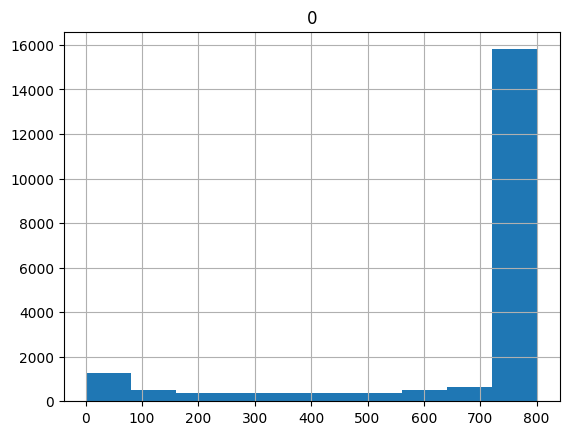

In [8]:
sizes = []
for column in X.columns:
    sizes.append(len(set(X[column])))

pd.DataFrame(sizes).hist()

In [9]:
UNIQUE_VALUES_CUTOFF=700

singular = []
for column in X.columns:
    if len(set(X[column])) < UNIQUE_VALUES_CUTOFF:
        singular += [column]
len(singular)

4522

In [10]:
X = X.drop(columns=singular)

array([[<Axes: title={'center': '0'}>]], dtype=object)

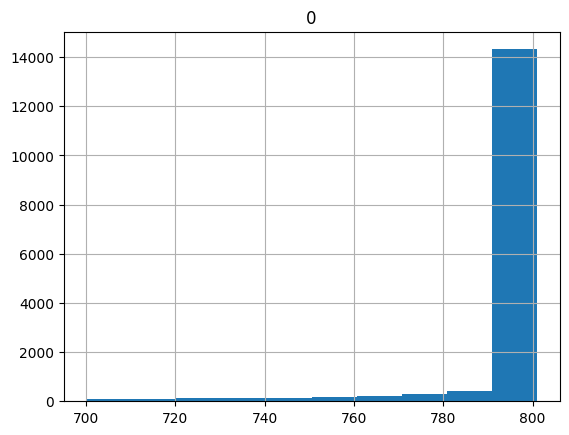

In [11]:
sizes = []
for column in X.columns:
    sizes.append(len(set(X[column])))

pd.DataFrame(sizes).hist()

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cols = list(X.columns)[1:]
X[cols] = scaler.fit_transform(X[cols])

In [13]:
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering
X = X.drop(columns=['Unnamed: 0'], errors="ignore")

kmeans = KMeans(n_clusters=len(set(y['Class'])))
kmeans_labels = kmeans.fit_predict(X, y['Class'])

birch = Birch(n_clusters=len(set(y['Class'])))
birch_labels = birch.fit_predict(X, y['Class'])

agg = AgglomerativeClustering(n_clusters=len(set(y['Class'])))
agg_labels = agg.fit_predict(X, y['Class'])

In [14]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X, kmeans_labels)
print(f'Silhouette score for KMeans: {sil_score}')

sil_score = silhouette_score(X, birch_labels)
print(f'Silhouette score for Birch: {sil_score}')

sil_score = silhouette_score(X, agg_labels)
print(f'Silhouette score for Agglomerative Clustering: {sil_score}')

Silhouette score for KMeans: 0.14581213744774274
Silhouette score for Birch: 0.14465494226621955
Silhouette score for Agglomerative Clustering: 0.14465494226621955


In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

COMPONENTS = 500

pca = PCA(n_components=COMPONENTS)
pca_components = pca.fit_transform(X)

In [16]:
kmeans_lodim = KMeans(n_clusters=len(set(y['Class'])))
kmeans_lodim_labels = kmeans_lodim.fit_predict(pca_components, y['Class'])

birch_lodim = Birch(n_clusters=len(set(y['Class'])))
birch_lodim_labels = birch_lodim.fit_predict(pca_components, y['Class'])

agg_lodim = AgglomerativeClustering(n_clusters=len(set(y['Class'])))
agg_lodim_labels = agg_lodim.fit_predict(pca_components, y['Class'])

In [17]:
sil_score_lodim = silhouette_score(X, kmeans_lodim_labels)
print(f'Silhouette score for KMeans low-dimensional data: {sil_score_lodim}')

sil_score_lodim = silhouette_score(X, birch_lodim_labels)
print(f'Silhouette score for Birch low-dimensional data: {sil_score_lodim}')

sil_score = silhouette_score(X, agg_lodim_labels)
print(f'Silhouette score for agg: {sil_score}')

Silhouette score for KMeans low-dimensional data: 0.14594439640265613
Silhouette score for Birch low-dimensional data: 0.14571310931854678
Silhouette score for agg: 0.14571310931854678


In [18]:
pca_2d = PCA(n_components=2)
pca_2d_components = pca_2d.fit_transform(X)
pca_2d_components

array([[-69.22720758,  87.92433751],
       [-18.01369646,  -6.36972946],
       [-66.10387072, -34.77024593],
       ...,
       [ -3.60129083,   7.49094407],
       [-33.41686588,  27.11652411],
       [-19.31143509,   1.55884968]], shape=(801, 2))

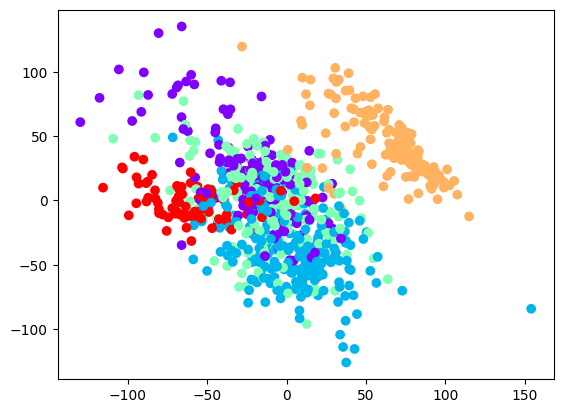

In [19]:
plt.scatter(pca_2d_components[:, 0], pca_2d_components[:, 1], c=agg_lodim_labels, cmap='rainbow')